In [16]:
import numpy as np

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.evaluation.evaluate_pattern_matching as epm
import matching.misc.cpg_const as cpg_const
from matching.glema.common.dataset import DesignPatternDataset
from matching.glema.common.model import InferenceGNN
import networkx as nx

In [2]:
args = arg_utils.parse_args( use_default=True )
args.dataset = "CPG_augm_large"
args.directed = True
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )
args = arg_utils.load_args( args, model_name )

args.dataset = "pmart_all"
args.pattern_dataset = "dpdf"
args.normalized = True
args.test_data = True
args.batch_size = 128
args.num_workers = 1

In [3]:
model = InferenceGNN( args )

Loading model from /Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/training/save/CPG_augm_large_directed_anchored_v2/model.pt ...


In [4]:
pattern_types = [
    #cpg_const.DesignPatternType.ABSTRACT_FACTORY.value,
    cpg_const.DesignPatternType.ADAPTER.value,
    cpg_const.DesignPatternType.BUILDER.value,
    # cpg_const.DesignPatternType.FACADE.value,
    cpg_const.DesignPatternType.FACTORY_METHOD.value,
    cpg_const.DesignPatternType.OBSERVER.value,
    cpg_const.DesignPatternType.SINGLETON.value,
    cpg_const.DesignPatternType.DECORATOR.value,
    cpg_const.DesignPatternType.MEMENTO.value,
    # cpg_const.DesignPatternType.PROXY.value,
    # cpg_const.DesignPatternType.VISITOR.value
]
dataset = DesignPatternDataset( args, max_pattern_examples=30, query_pattern=True, pattern_types=pattern_types )
up_sources = dataset.get_sources()
up_patterns = dataset.get_patterns()

Loading sources from pmart_all ...


100%|██████████| 1267/1267 [00:00<00:00, 2800.86it/s]


Loading sources from dpdf ...


100%|██████████| 7469/7469 [00:03<00:00, 2015.39it/s]


In [5]:
min_nodes = 5
max_norm_d = 12

p_sources = up_sources
p_sources = epm.filter_sources( p_sources, dataset.get_source_patterns(),
                                max_sources_per_pattern=-1, max_na_patterns=5 )
p_sources = epm.normalize_sources( p_sources, max_distance=max_norm_d, min_nodes=min_nodes )

p_patterns = up_patterns
p_patterns = epm.normalize_patterns( p_patterns, max_distance=max_norm_d, min_nodes=min_nodes )
#p_patterns = epm.get_common_patterns( p_patterns, max_node_distance=max_norm_d, min_nodes=5 )

dataset.set_sources( p_sources )
dataset.set_patterns( p_patterns )
dataset.compute_samples()

epm.print_pattern_counts( dataset )

Filtering sources ...


100%|██████████| 1267/1267 [00:00<00:00, 3884636.82it/s]


Normalizing sources ...


100%|██████████| 216/216 [00:00<00:00, 519.80it/s]


Normalizing patterns ...


100%|██████████| 7/7 [00:00<00:00, 64.86it/s]

source_pattern_counts: {'ADAPTER': 11, 'BUILDER': 24, 'DECORATOR': 34, 'FACTORY_METHOD': 40, 'MEMENTO': 12, 'N/A': 3, 'OBSERVER': 60, 'SINGLETON': 6}
pattern_instance_counts: {'ADAPTER': 5, 'BUILDER': 3, 'DECORATOR': 3, 'FACTORY_METHOD': 6, 'MEMENTO': 2, 'N/A': 3, 'OBSERVER': 10, 'SINGLETON': 6}
pattern_example_counts: {'ADAPTER': 16, 'BUILDER': 17, 'DECORATOR': 9, 'FACTORY_METHOD': 16, 'MEMENTO': 4, 'OBSERVER': 19, 'SINGLETON': 15}


In [6]:
def count_node_numbers( graphs: list[nx.Graph], interval_width ):
    arr = [ graph.number_of_nodes() for graph in graphs ]
    # Determine the maximum value in the array to know how many intervals to create.
    max_val = max( arr ) if arr else 0

    intervals = { }
    # Create intervals from 0 up to a bit past the maximum value.
    for start in range( 0, max_val + interval_width, interval_width ):
        end = start + interval_width
        key = f"{start}-{end}"
        intervals[ key ] = [ x for x in arr if start <= x < end ]
        
    counts = { key: len( nns ) for key, nns in intervals.items() }
    return intervals, counts

source_nn_results, source_nn_counts = count_node_numbers( dataset.get_sources().values(), 5 )
print( f"sources nns: {source_nn_counts}" )

pattern_graphs = []
for ps in dataset.get_patterns().values():
    pattern_graphs.extend( ps )
pattern_nn_results, pattern_nn_counts = count_node_numbers( pattern_graphs, 5 )
print( f"pattern nns: {pattern_nn_counts}" )

sources nns: {'0-5': 0, '5-10': 48, '10-15': 17, '15-20': 19, '20-25': 19, '25-30': 15, '30-35': 9, '35-40': 12, '40-45': 11, '45-50': 7, '50-55': 8, '55-60': 3, '60-65': 3, '65-70': 5, '70-75': 4, '75-80': 2, '80-85': 0, '85-90': 0, '90-95': 3, '95-100': 2, '100-105': 0, '105-110': 0, '110-115': 1, '115-120': 0, '120-125': 0, '125-130': 1, '130-135': 1, '135-140': 0}
pattern nns: {'0-5': 0, '5-10': 28, '10-15': 15, '15-20': 6, '20-25': 11, '25-30': 12, '30-35': 2, '35-40': 2, '40-45': 4, '45-50': 3, '50-55': 1, '55-60': 0, '60-65': 1, '65-70': 0, '70-75': 1, '75-80': 2, '80-85': 1, '85-90': 3, '90-95': 1, '95-100': 0, '100-105': 1, '105-110': 0, '110-115': 0, '115-120': 0, '120-125': 1, '125-130': 0, '130-135': 0, '135-140': 0, '140-145': 0, '145-150': 0, '150-155': 0, '155-160': 0, '160-165': 0, '165-170': 0, '170-175': 0, '175-180': 1, '180-185': 0}


In [7]:
preds, metas, sources, queries = epm.inference( model, dataset, args,
                                                #sample_processor=epm.sample_processor_k_normalized,
                                                #min_d_offset=1, max_d_offset=2,
                                                #sample_processor=epm.sample_processor_path_match_weighted,
                                                collect_graphs=True )

print( f"source: {len( sources )} / queries: {len( queries )}" )
print( f"preds: {len( preds )} / metas: {len( metas )}" )
print( "meta example:", metas[ 0 ] )

Inference of dataset ...


100%|██████████| 143/143 [00:20<00:00,  7.01it/s]

source: 18240 / queries: 18240
preds: 18240 / metas: 18240
meta example: {'source_type': 'N/A', 'pattern_type': 'SINGLETON', 'gidx': 726, 'record_scope': 'Object', 'record_dataset': 'p_mart-1_-_quickuml_2001', 'pattern_id': 726, 'pred_w': 1.0}


In [8]:
by_source = False
by_grouped_instance = False

groups_by_source = epm.group_by_source( metas )
groups_by_instance = epm.group_by_pattern_instance( metas )
if by_grouped_instance:
    groups_by_source = groups_by_instance

source_preds = epm.compute_source_preds( groups_by_source, preds, metas,
                                         #pred_aggregator=epm.aggregate_preds_max,
                                         pred_aggregator=epm.aggregate_preds_by_quantile, q=0.999
                                         )
source_types = epm.compute_source_types( groups_by_source, metas )

conf_step = 0.8
if by_source or by_grouped_instance:
    #true_labels, pred_labels, pred_scores = epm.compute_labels( source_types, source_preds, conf=conf_step )
    true_labels, pred_labels, pred_scores = epm.compute_labels_legacy( source_types, source_preds, conf=conf_step )
    groups = groups_by_source
else:
    true_labels, pred_labels, pred_scores = epm.compute_labels_by_instance( source_types, source_preds, groups_by_instance, metas, conf=conf_step )
    groups = groups_by_instance

In [9]:
x_labels, y_labels = epm.to_numeric_labels( true_labels, pred_labels )
metrics = epm.compute_metrics( x_labels, y_labels )
metrics[ "conf" ] = conf_step
print( f"Roc=[{metrics[ 'roc' ]:.3}] Acc=[{metrics[ 'acc' ]:.3}] "
       f"Prec=[{metrics[ 'pre' ]:.3}] Rec=[{metrics[ 'rec' ]:.3}] F1=[{metrics[ 'f1s' ]:.3}] "
       f"AvgPrec=[{metrics[ 'avp' ]:.3}]" )

Roc=[0.656] Acc=[0.394] Prec=[0.359] Rec=[0.412] F1=[0.377] AvgPrec=[0.291]


In [10]:
epm.get_result_df( groups, metas, true_labels, pred_labels, pred_scores )

,gidx,dataset,record,true_type,pred_type,pred_score
0,726,p_mart-1_-_quickuml_2001,Object,N/A,N/A,0.799975
1,430,p_mart-11_-_pmd_v18,net.sourceforge.pmd.rules.design.LongParameter...,N/A,N/A,0.544426
2,918,p_mart-5_-_junit_v37,junit.extensions.ActiveTestSuite,N/A,ADAPTER,0.994448
3,1327,p_mart-6_-_jhotdraw_v51,CH.ifa.draw.framework.FigureChangeListener#81,OBSERVER,MEMENTO,0.992326
4,1328,p_mart-6_-_jhotdraw_v51,CH.ifa.draw.framework.Drawing#82,OBSERVER,FACTORY_METHOD,0.960341
5,1346,p_mart-8_-_mapperxml_v197,com.taursys.xml.Trigger#100,FACTORY_METHOD,FACTORY_METHOD,0.989594
6,1347,p_mart-8_-_mapperxml_v197,com.taursys.xml.CheckboxField#101,OBSERVER,FACTORY_METHOD,0.992727
7,1382,p_mart-11_-_pmd_v18,net.sourceforge.pmd.util.viewer.model.ViewerMo...,OBSERVER,OBSERVER,0.983693
8,1252,p_mart-1_-_quickuml_2001,diagram.tool.AbstractTool#6,OBSERVER,OBSERVER,0.983478
9,1314,p_mart-5_-_junit_v37,junit.swingui.TestRunner#68,DECORATOR,ADAPTER,0.990958


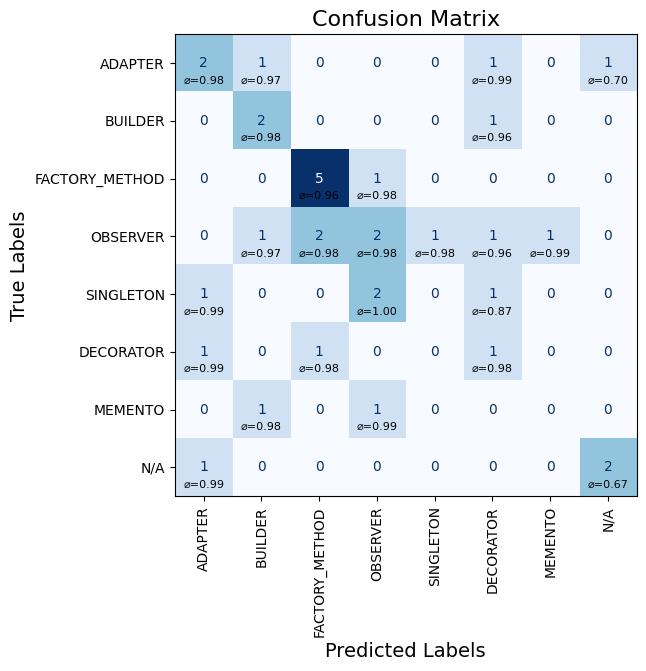

In [11]:
epm.compute_cm( true_labels, pred_labels, pred_scores, labels=pattern_types )

In [12]:
_, source_nn_counts = count_node_numbers( sources, 5 )
_, query_nn_counts = count_node_numbers( queries, 5 )
print( f"source: {source_nn_counts}" )
print( f"query: {query_nn_counts}" )

source: {'0-5': 0, '5-10': 4608, '10-15': 1632, '15-20': 1824, '20-25': 1824, '25-30': 1440, '30-35': 864, '35-40': 1152, '40-45': 1056, '45-50': 672, '50-55': 768, '55-60': 288, '60-65': 288, '65-70': 480, '70-75': 384, '75-80': 192, '80-85': 0, '85-90': 0, '90-95': 288, '95-100': 192, '100-105': 0, '105-110': 0, '110-115': 96, '115-120': 0, '120-125': 0, '125-130': 96, '130-135': 96, '135-140': 0}
query: {'0-5': 0, '5-10': 8584, '10-15': 3031, '15-20': 1643, '20-25': 1850, '25-30': 1404, '30-35': 342, '35-40': 366, '40-45': 380, '45-50': 211, '50-55': 129, '55-60': 36, '60-65': 55, '65-70': 55, '70-75': 54, '75-80': 36, '80-85': 8, '85-90': 24, '90-95': 17, '95-100': 6, '100-105': 3, '105-110': 0, '110-115': 2, '115-120': 0, '120-125': 2, '125-130': 1, '130-135': 1, '135-140': 0}


In [14]:
metas[0]

{'source_type': 'N/A',
 'pattern_type': 'SINGLETON',
 'gidx': 726,
 'record_scope': 'Object',
 'record_dataset': 'p_mart-1_-_quickuml_2001',
 'pattern_id': 726,
 'pred_w': 1.0}

<Axes: title={'center': 'Combined [p=0.9957]'}>

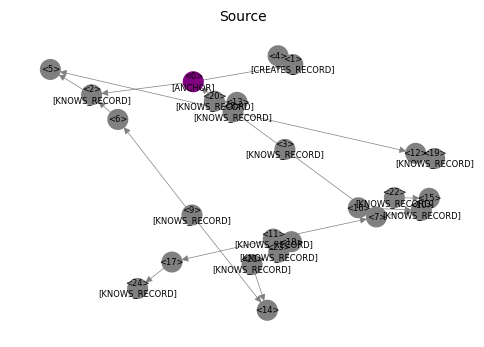

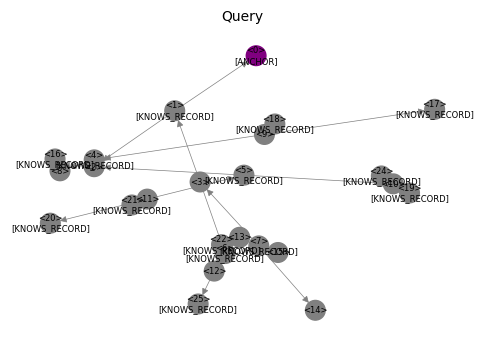

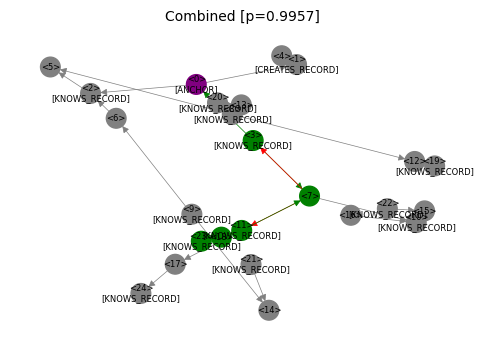

In [55]:
matching_examples = epm.get_matching_examples( pattern_types, sources, queries, 
                                               preds, metas, min_nodes=10, max_nodes=30 )
example = matching_examples[(
    cpg_const.DesignPatternType.OBSERVER.value,
    cpg_const.DesignPatternType.OBSERVER.value
)]     
plot_utils.plot_graph( example[ "source" ], title=f"Source", 
                               nodeColors=graph_utils.get_node_colors( example[ "source" ] ),
                               nodeLabels=graph_utils.get_node_labels( example[ "source" ] ) )
plot_utils.plot_graph( example[ "query" ], title=f"Query", 
                       nodeColors=graph_utils.get_node_colors( example[ "query" ] ),
                       nodeLabels=graph_utils.get_node_labels( example[ "query" ] ) )

matching_colors = { 2: "purple", 1: "green", 0: "grey", -1: "red" }
combined, node_colors, edge_colors = graph_utils.combine_normalized( example[ "source" ], example[ "query" ], matching_colors=matching_colors )
plot_utils.plot_graph( combined,
                       title=f"Combined [p={example[ 'pred' ]:.4}]",
                       nodeLabels=graph_utils.get_node_labels( combined ),
                       nodeColors=node_colors, edgeColors=edge_colors )

In [ ]:
raise ValueError

Should be: OBSERVER
FACTORY_METHOD: 0.99
ADAPTER: 0.978
OBSERVER: 0.975
BUILDER: 0.93
SINGLETON: 0.868
DECORATOR: 0.244
MEMENTO: 0.000207
{'source_type': 'OBSERVER', 'pattern_type': 'SINGLETON', 'gidx': 1094, 'record_scope': 'com.taursys.xml.event.test.InputDispatcherTest.TestComponent#100', 'record_dataset': 'p_mart-8_-_mapperxml_v197', 'pattern_id': 1346, 'pred_w': 1.0}
{'source_type': 'OBSERVER', 'pattern_type': 'FACTORY_METHOD', 'gidx': 1094, 'record_scope': 'com.taursys.xml.event.test.InputDispatcherTest.TestComponent#100', 'record_dataset': 'p_mart-8_-_mapperxml_v197', 'pattern_id': 1346, 'pred_w': 1.0}
{'source_type': 'OBSERVER', 'pattern_type': 'ADAPTER', 'gidx': 1094, 'record_scope': 'com.taursys.xml.event.test.InputDispatcherTest.TestComponent#100', 'record_dataset': 'p_mart-8_-_mapperxml_v197', 'pattern_id': 1346, 'pred_w': 1.0}
{'source_type': 'OBSERVER', 'pattern_type': 'OBSERVER', 'gidx': 1094, 'record_scope': 'com.taursys.xml.event.test.InputDispatcherTest.TestComponent#

/Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/common/utils/plot_utils.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots( figsize=figsize )


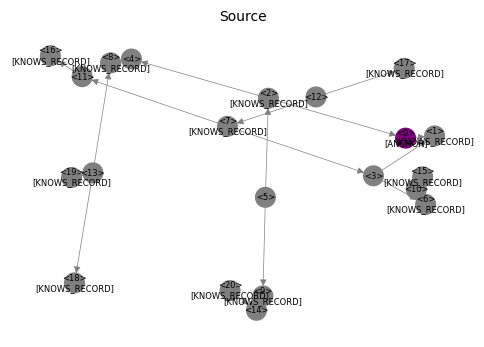

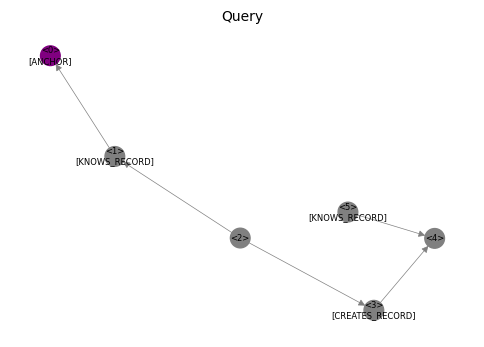

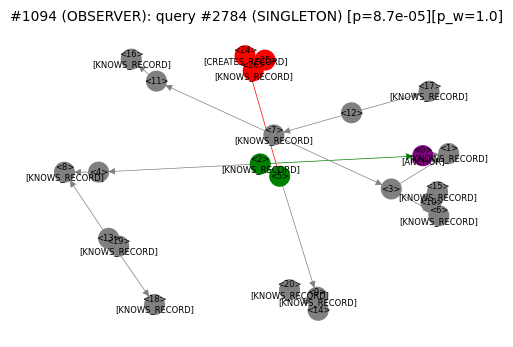

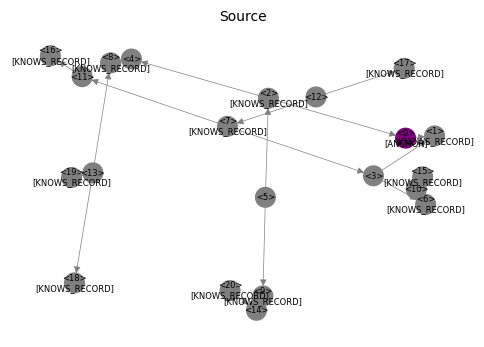

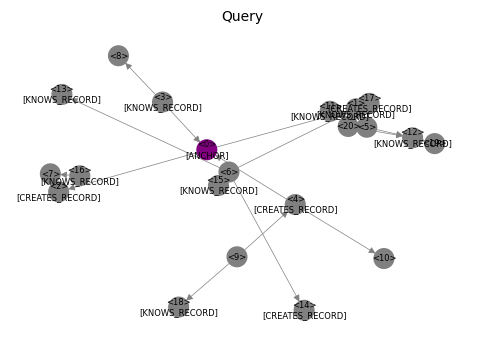

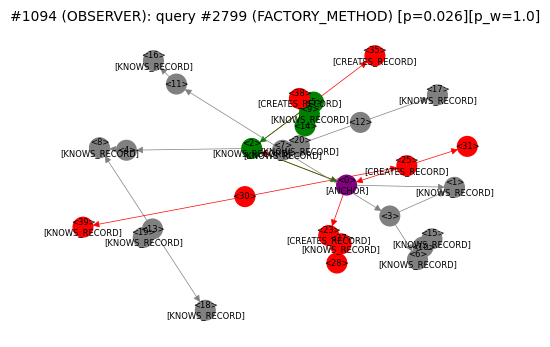

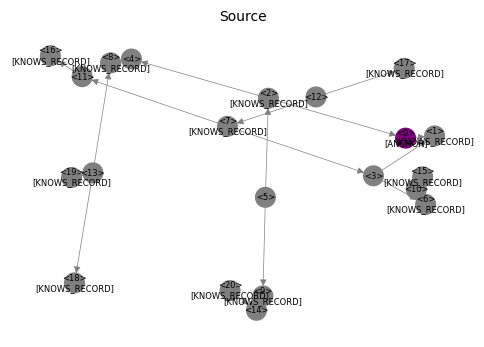

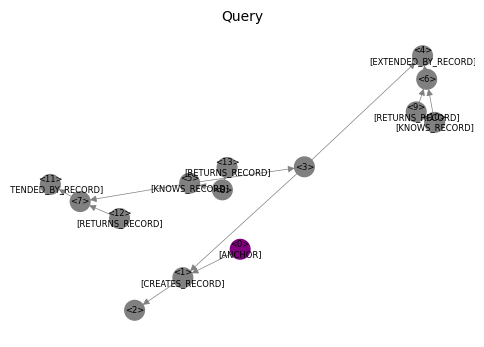

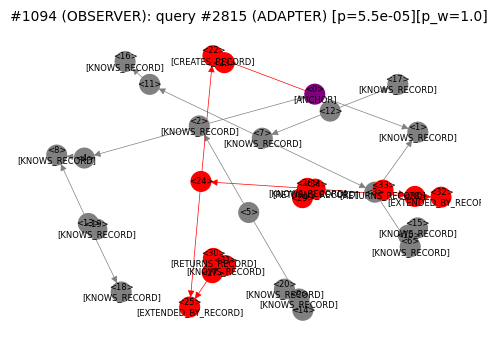

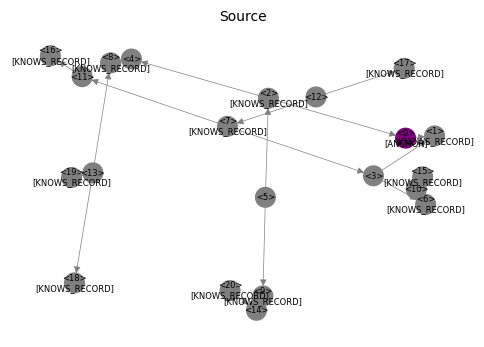

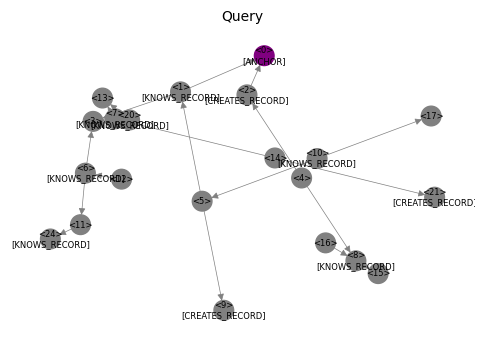

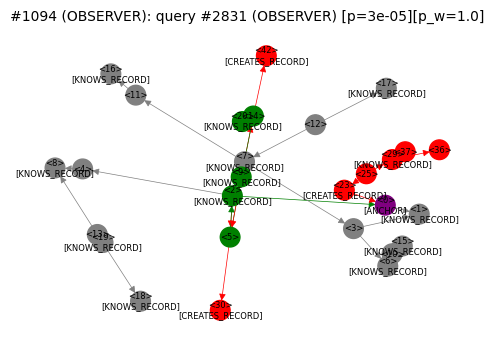

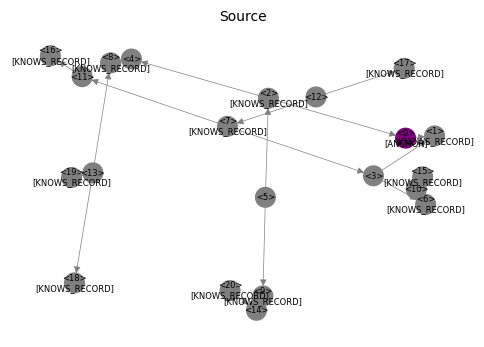

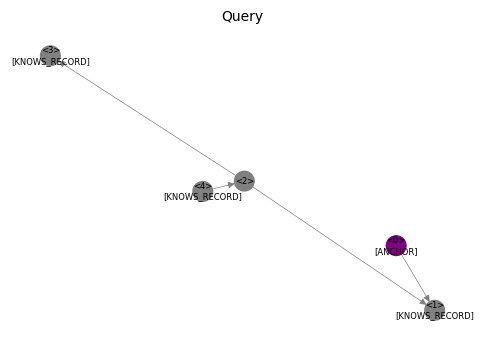

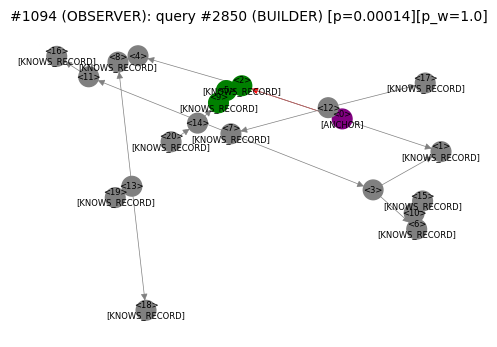

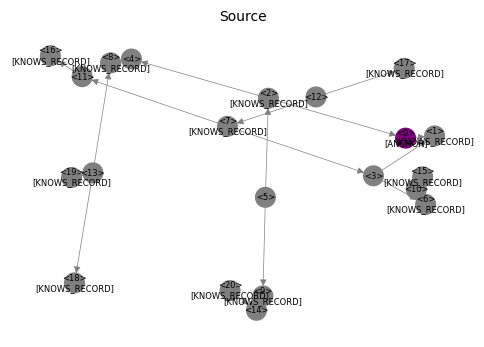

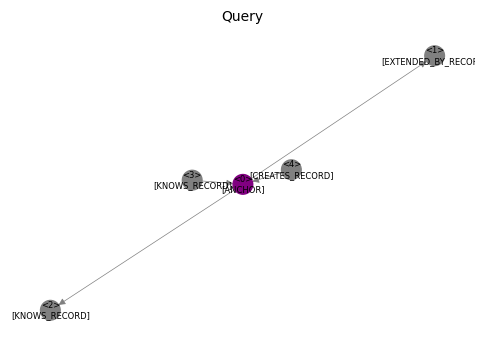

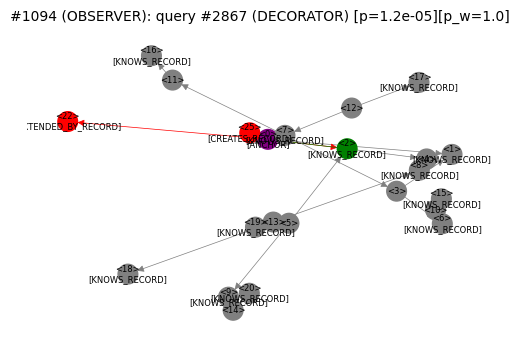

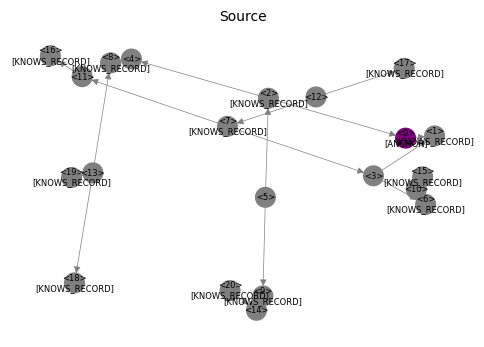

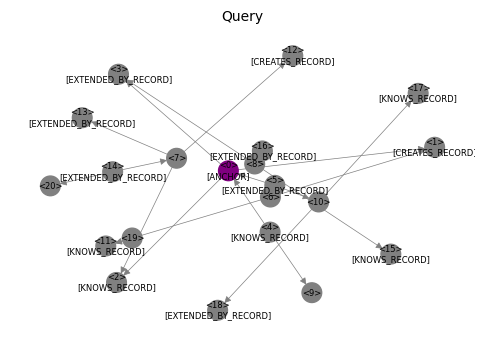

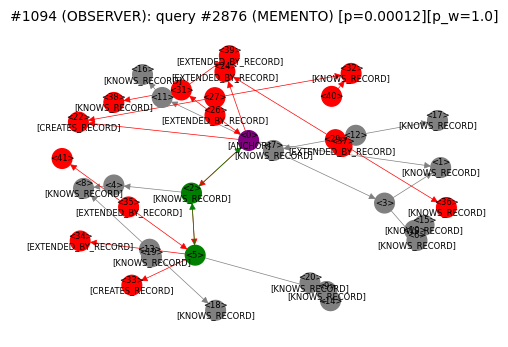

In [13]:
matching_colors = { 2: "purple", 1: "green", 0: "grey", -1: "red" }
example_gidx = -1
source_iter = iter( groups_by_source )
for _ in range( 30 ):
    example_gidx = next( source_iter )
print( f"Should be: {dataset.get_source_patterns()[ example_gidx ]}" )
for pattern_type, score in misc_utils.sort_dict_by_value(
        source_preds[ example_gidx ], reverse=True ).items():
    print( f"{pattern_type}: {score:.3}" )
for pattern_type, idxs in groups_by_source[ example_gidx ].items():
    for idx in idxs[ :1 ]:
        source = sources[ idx ]
        query = queries[ idx ]
        plot_utils.plot_graph( source, title=f"Source", 
                               nodeColors=graph_utils.get_node_colors( source ),
                               nodeLabels=graph_utils.get_node_labels( source ) )
        plot_utils.plot_graph( query, title=f"Query", 
                               nodeColors=graph_utils.get_node_colors( query ),
                               nodeLabels=graph_utils.get_node_labels( query ) )
        
        pred = preds[ idx ]
        meta = metas[ idx ]
        print( meta )
        source_type = meta.get( "source_type" )
        gidx = meta.get( "gidx" )
        p_w = meta.get( "pred_w", 1.0 )
        combined, node_colors, edge_colors = graph_utils.combine_normalized(
            source, query, matching_colors=matching_colors )
        plot_utils.plot_graph( combined,
                               title=f"#{gidx} ({source_type}): query #{idx} ({pattern_type}) [p={pred:.2}][p_w={p_w:.2}]",
                               nodeLabels=graph_utils.get_node_labels( combined ),
                               nodeColors=node_colors, edgeColors=edge_colors )